<a href="https://colab.research.google.com/github/sgcortes/2023_NAPLES/blob/main/Optuna_250225_GBR_NO_AGUA_NO_ALTITUD_HIPERPRAMETROS_PREDICCION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AJUSTE FINO HIPERPARAMETROS

## **Optuna**

Optuna es un framework de optimización automática de hiperparámetros diseñado para hacer que el proceso de ajuste de modelos de machine learning sea más eficiente y flexible. Aquí te detallo sus aspectos clave:

**Conceptos Fundamentales:**
+ Estudios (Studies):
Un estudio en Optuna representa un proceso completo de optimización. Contiene todas las pruebas y los resultados asociados.
+ Pruebas (Trials):
Una prueba es un intento de evaluar un conjunto específico de hiperparámetros. Optuna explora diferentes combinaciones de hiperparámetros a través de múltiples pruebas.
+ Función Objetivo:
Debes definir una función objetivo que Optuna intentará minimizar o maximizar. Esta función generalmente evalúa el rendimiento de tu modelo utilizando un conjunto de validación.

**Características Distintivas:**

+ Define-by-Run:
Optuna permite definir el espacio de búsqueda de hiperparámetros de forma dinámica dentro de la función objetivo. Esto proporciona una gran flexibilidad, especialmente cuando los hiperparámetros dependen unos de otros.
+ Algoritmos de Muestreo Eficientes:
Optuna implementa algoritmos de muestreo avanzados que le permiten explorar el espacio de búsqueda de manera eficiente. Esto incluye algoritmos basados en procesos gaussianos y otros métodos bayesianos.
+ Poda (Pruning):
Optuna puede podar automáticamente las pruebas que muestran un rendimiento deficiente durante el entrenamiento. Esto ahorra tiempo y recursos al evitar la evaluación completa de combinaciones de hiperparámetros poco prometedoras.

**Visualizaciones:**
Optuna proporciona herramientas de visualización que te permiten analizar el proceso de optimización. Puedes ver la importancia de los hiperparámetros, la evolución del rendimiento y otras métricas útiles.
Integración:
Optuna se integra fácilmente con muchos frameworks de machine learning populares, como scikit-learn, TensorFlow, PyTorch y XGBoost.
En resumen:

Optuna se destaca por su flexibilidad, eficiencia y facilidad de uso. Su capacidad "define-by-run" y sus algoritmos de muestreo avanzados lo convierten en una herramienta poderosa para la optimización de hiperparámetros en una amplia gama de aplicaciones de machine learning.
### Visualizaciones incluidas:
Importancia de los hiperparámetros (plot_param_importances)
Evolución del rendimiento a lo largo de las iteraciones (plot_optimization_history)
Relaciones entre hiperparámetros y el rendimiento (plot_slice)
Matriz de interacciones entre los hiperparámetros (plot_parallel_coordinate)

## LECTURA DE DATOS Y ENTRENAMIENTO MODELO

In [ ]:
!pip install optuna

In [ ]:
import sklearn
print(sklearn.__version__)
import joblib
print(joblib.__version__)

1.6.1
1.4.2


[I 2025-03-05 11:33:31,468] A new study created in memory with name: no-name-fe7bf284-dc4c-46f8-a2aa-44dc7623e2cc
<ipython-input-50-4c4c2a5e80e0>:40: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-50-4c4c2a5e80e0>:40: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-05 11:33:32,715] Trial 1 finished with value: 0.34422222813105996 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.013116757886145294, 'subsample': 0.9890941757794283}. Best is trial 1 with value: 0.34422222813105996.
<ipython-input-50-4c4c2a5e80e0>:40: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

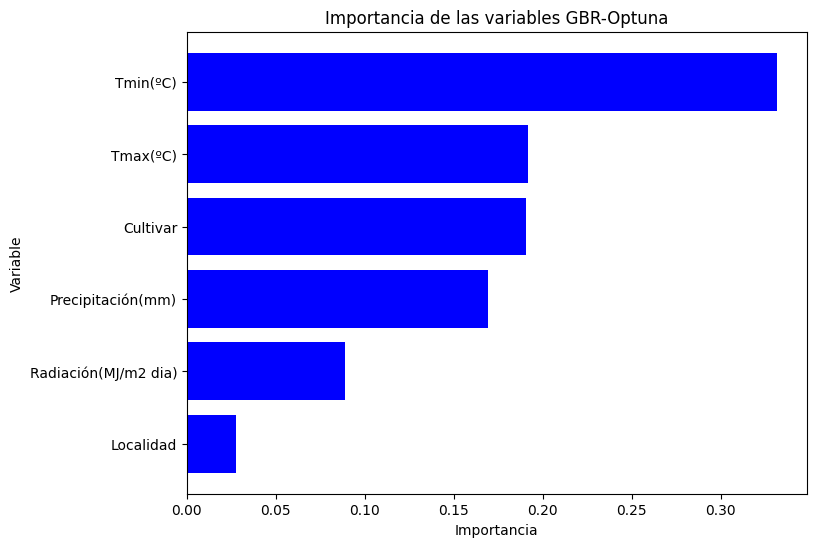

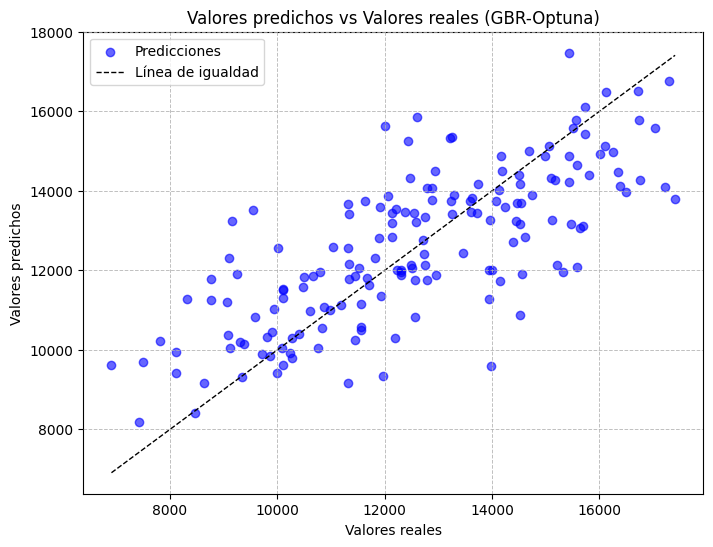

{'Mejores hiperparámetros': {'n_estimators': 100,
  'max_depth': 3,
  'learning_rate': 0.10813643584331145,
  'subsample': 0.7330309211465338},
 'Métricas mejor modelo': {'MAE': 1242.396278087393,
  'MSE': 2577809.689289893,
  'RMSE': 1605.5558817088531,
  'R²': 0.5605577161550048},
 'Enlace modelo optimizado': 'gradient_boosting_optuna.pkl'}

In [ ]:
# Reimportar las bibliotecas necesarias para la optimización con Optuna
# Reimportar las bibliotecas necesarias después del reinicio
import pandas as pd
import numpy as np
import optuna
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cargar los datos nuevamente
file_path = "/content/DatosmodeloRaigrasfinalv10-yield.xlsx"
df = pd.read_excel(file_path)

# Seleccionar las variables predictoras y la variable objetivo
features = ['Localidad', 'Cultivar', 'Tmax(ºC)', 'Tmin(ºC)', 'Precipitación(mm)', 'Radiación(MJ/m2 dia)']
target = 'kg MS/ha'

# Codificar las variables categóricas
label_encoders = {}
for col in ['Localidad', 'Cultivar']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Definir X e y
X = df[features]
y = df[target]

# Configurar validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir la función objetivo para la optimización con Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    max_depth = trial.suggest_int('max_depth', 2, 6)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    subsample = trial.suggest_float('subsample', 0.7, 1.0)

    # Crear el modelo con los hiperparámetros sugeridos
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42
    )

    # Evaluar el modelo con validación cruzada
    score = cross_val_score(model, X, y, cv=kf, scoring='r2').mean()

    return score

# Ejecutar la optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1)

# Obtener los mejores hiperparámetros encontrados
best_params = study.best_params

# Ajustar el mejor modelo con los hiperparámetros óptimos
best_model = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    random_state=42
)

# Evaluar el mejor modelo con validación cruzada
y_pred_best = cross_val_predict(best_model, X, y, cv=kf)

# Calcular métricas de evaluación para el mejor modelo
mae_best = mean_absolute_error(y, y_pred_best)
mse_best = mean_squared_error(y, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y, y_pred_best)

# Ajustar el modelo final con todos los datos
best_model.fit(X, y)

# Guardar el modelo ajustado con Optuna
model_optuna_path = "gradient_boosting_optuna.pkl"
joblib.dump(best_model, model_optuna_path)

# Obtener importancia de las variables del mejor modelo
importances_best = best_model.feature_importances_
importance_df_best = pd.DataFrame({"Variable": features, "Importancia": importances_best})
importance_df_best = importance_df_best.sort_values(by="Importancia", ascending=False)

# Gráfica de importancia de las variables
plt.figure(figsize=(8, 6))
plt.barh(importance_df_best["Variable"], importance_df_best["Importancia"], color='blue')
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.title("Importancia de las variables GBR-Optuna")
plt.gca().invert_yaxis()
plt.show()

# Gráfica de valores predichos vs reales
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_best, color='blue', alpha=0.6, label="Predicciones")
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=1, label="Línea de igualdad")
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.8)
plt.gca().set_axisbelow(False)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Valores predichos vs Valores reales (GBR-Optuna)")
plt.legend()

plt.show()

# Mostrar resultados
{
    "Mejores hiperparámetros": best_params,
    "Métricas mejor modelo": {"MAE": mae_best, "MSE": mse_best, "RMSE": rmse_best, "R²": r2_best},
    "Enlace modelo optimizado": model_optuna_path
}


### Visualizacion de hiperparametros (Optuna)

In [ ]:
import optuna.visualization as ov

# 1️⃣ Importancia de los hiperparámetros en el rendimiento
fig_importance = ov.plot_param_importances(study)
fig_importance.show()

# 2️⃣ Evolución del rendimiento en función de las iteraciones
fig_history = ov.plot_optimization_history(study)
fig_history.show()

# 3️⃣ Relación entre hiperparámetros y rendimiento
fig_slice = ov.plot_slice(study)
fig_slice.show()

# 4️⃣ Matriz de interacciones entre los hiperparámetros optimizados
fig_parallel = ov.plot_parallel_coordinate(study)
fig_parallel.show()


## PREDICCION
Asegúrate de que los archivos necesarios estén en la misma carpeta que el script:
PrediccionesGBR-Brigantia.xlsx (con las muestras a predecir).
gradient_boosting_optuna.pkl (modelo entrenado).
Ejecuta el script en Python.
El archivo con las predicciones se generará como PrediccionesGBR-Brigantia-Predicho.xlsx.
📌 Resultado esperado:

Se imprimen en pantalla los diccionarios con la codificación de Localidad y Cultivar.
Se genera un nuevo archivo con la columna kg MS/ha_pred, que contiene las predicciones del modelo.

### Carga de datos

In [ ]:
import pandas as pd

# Cargar los datos del archivo Excel
file_path = "DatosmodeloRaigrasfinalv10-yield.xlsx"
xls = pd.ExcelFile(file_path)
# Cargar los datos de la hoja correspondiente
df = pd.read_excel(xls, sheet_name="Hoja1")

# Mostrar las primeras filas para inspección
df.head()

,Localidad,Cultivar,Altitud (m),AguadisponibleSuelo(mm),Tmax(ºC),Tmin(ºC),Precipitación(mm),Radiación(MJ/m2 dia),kg MS/ha
0,Mabegondo,Brigantia,100,102,24.8,2.7,1223.4,13.9,12300
1,Mabegondo,Brigantia,100,102,22.8,2.9,1070.5,12.9,11630
2,Mabegondo,Brigantia,100,102,24.8,2.6,1186.5,13.2,13290
3,Mabegondo,Brigantia,100,102,24.0,3.3,912.3,13.7,13740
4,Mabegondo,Brigantia,100,102,25.6,4.6,928.1,14.3,14190


### Estadísticas por localidad

In [ ]:
# Calcular estadísticas por localidad
stats = df.groupby("Localidad").agg({
    "Tmax(ºC)": "mean",
    "Tmin(ºC)": ["min", "mean", "max"],
    "Precipitación(mm)": ["min", "mean", "max"],
    "Radiación(MJ/m2 dia)": "mean"
})

# Renombrar columnas para facilidad de acceso
stats.columns = ["Tmax_mean", "Tmin_min", "Tmin_mean", "Tmin_max",
                 "Precip_min", "Precip_mean", "Precip_max", "Rad_mean"]

# Mostrar estadísticas calculadas
stats


,Tmax_mean,Tmin_min,Tmin_mean,Tmin_max,Precip_min,Precip_mean,Precip_max,Rad_mean
Localidad,,,,,,,,
Grado,23.970909,5.4,6.160000,7.2,632.8,766.496364,944.0,13.132727
Mabegondo,24.436842,2.4,3.214035,4.6,859.6,1069.847368,1376.4,13.650877
Puebla,24.462500,0.8,1.748214,3.0,648.6,854.676786,1144.3,14.426786


### Muestras sintéticas

In [ ]:
import numpy as np
# Inicializar listas para almacenar datos sintéticos
data = []

# Definir número de observaciones por categoría
n_samples = 30

# Generar datos sintéticos para cada localidad y condición climática
for localidad, row in stats.iterrows():
    for condition in ["desfavorable", "favorable"]:
        for _ in range(n_samples):
            if condition == "desfavorable":
                Tmin = np.random.uniform(row["Tmin_min"], row["Tmin_mean"])
                Precip = np.random.uniform(row["Precip_min"], row["Precip_mean"])
            else:
                Tmin = np.random.uniform(row["Tmin_mean"], row["Tmin_max"])
                Precip = np.random.uniform(row["Precip_mean"], row["Precip_max"])

            Tmax = row["Tmax_mean"]
            Radiacion = row["Rad_mean"]

            data.append([localidad, "Brigantia", Tmax, Tmin, Precip, Radiacion])

# Crear DataFrame con los datos generados
df_synthetic = pd.DataFrame(data, columns=["Localidad", "Cultivar", "Tmax(ºC)", "Tmin(ºC)", "Precipitación(mm)", "Radiación(MJ/m2 dia)"])

# Mostrar las primeras filas del DataFrame generado
df_synthetic.head()

# Guardar el DataFrame en un archivo Excel
output_file = "PrediccionesGBR-Brigantia.xlsx"
df_synthetic.to_excel(output_file, index=False)

# Proporcionar enlace de descarga
output_file


'PrediccionesGBR-Brigantia.xlsx'

### Codificación vars. categóricas y Predicción

In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# Ruta del archivo Excel con las muestras sintéticas
input_file = "PrediccionesGBR-Brigantia.xlsx"

# Ruta del modelo entrenado en formato pckl
model_path = "gradient_boosting_optuna.pkl"

# Leer el archivo Excel con las muestras a predecir
df = pd.read_excel(input_file)

# Codificar las variables categóricas
le_localidad = LabelEncoder()
le_cultivar = LabelEncoder()

# Ajustar y transformar las variables categóricas
df["Localidad"] = le_localidad.fit_transform(df["Localidad"])
df["Cultivar"] = le_cultivar.fit_transform(df["Cultivar"])

# Diccionarios de equivalencias
localidad_mapping = dict(zip(le_localidad.classes_, le_localidad.transform(le_localidad.classes_)))
cultivar_mapping = dict(zip(le_cultivar.classes_, le_cultivar.transform(le_cultivar.classes_)))

# Mostrar los diccionarios de equivalencias
print("Codificación de Localidad:", localidad_mapping)
print("Codificación de Cultivar:", cultivar_mapping)

# Seleccionar las variables predictoras en el orden correcto
feature_columns = ["Localidad", "Cultivar", "Tmax(ºC)", "Tmin(ºC)", "Precipitación(mm)", "Radiación(MJ/m2 dia)"]
X = df[feature_columns]

# Cargar el modelo Gradient Boosting
model = joblib.load(model_path)

# Realizar predicciones
df["kg MS/ha_pred"] = model.predict(X)

# Invertir los diccionarios de mapeo para decodificar los valores
localidad_decoding = {v: k for k, v in localidad_mapping.items()}
cultivar_decoding = {v: k for k, v in cultivar_mapping.items()}

# Reemplazar los códigos por los valores originales
df["Localidad"] = df["Localidad"].map(localidad_decoding)
df["Cultivar"] = df["Cultivar"].map(cultivar_decoding)

## Mostrar las primeras filas del dataframe actualizado
print(df.head())

# Guardar el DataFrame con las predicciones en un nuevo archivo Excel
output_file = "PrediccionesGBR-Brigantia-Predicho.xlsx"
df.to_excel(output_file, index=False)

print(f"Archivo generado: {output_file}")


Codificación de Localidad: {'Grado': 0, 'Mabegondo': 1, 'Puebla': 2}
Codificación de Cultivar: {'Brigantia': 0}
  Localidad   Cultivar   Tmax(ºC)  Tmin(ºC)  Precipitación(mm)  \
0     Grado  Brigantia  23.970909  5.452034         750.625438   
1     Grado  Brigantia  23.970909  6.081790         675.094479   
2     Grado  Brigantia  23.970909  5.523111         693.857733   
3     Grado  Brigantia  23.970909  5.880155         656.267382   
4     Grado  Brigantia  23.970909  5.843347         693.749595   

   Radiación(MJ/m2 dia)  kg MS/ha_pred  
0             13.132727   15146.889780  
1             13.132727   13943.526566  
2             13.132727   15537.593039  
3             13.132727   15265.846574  
4             13.132727   14156.300067  
Archivo generado: PrediccionesGBR-Brigantia-Predicho.xlsx


### Gráfica por Cultivar para año favorable y desfavorable

<Figure size 1000x600 with 0 Axes>

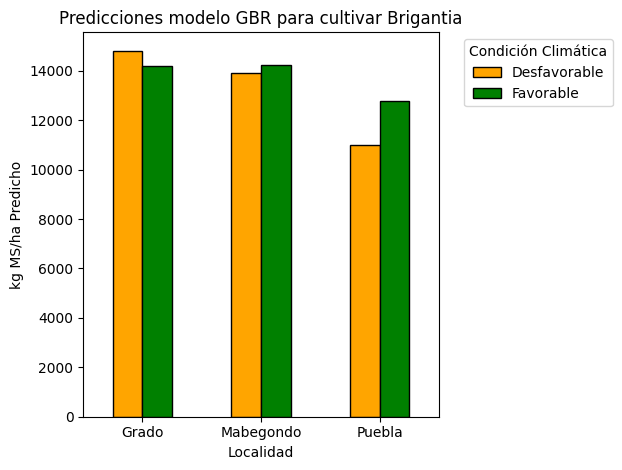

In [ ]:
# Cargar el archivo con las predicciones
file_path = "PrediccionesGBR-Brigantia-Predicho.xlsx"
df_pred = pd.read_excel(file_path)

# Contar cuántas muestras hay por localidad
samples_per_localidad = len(df_pred) // 3  # Suponiendo 3 localidades
half_samples = samples_per_localidad // 2  # La mitad son desfavorables, la otra mitad favorables

# Crear una lista de etiquetas de condición climática
condition_labels = (["Desfavorable"] * half_samples + ["Favorable"] * half_samples) * 3

# Asignar la columna de condición climática al DataFrame
df_pred["Condicion"] = condition_labels

# Crear la figura
plt.figure(figsize=(10, 6))

# Agrupar por localidad y condición para calcular la media
grouped = df_pred.groupby(["Localidad", "Condicion"])["kg MS/ha_pred"].mean().unstack()

# Crear la gráfica de barras
ax = grouped.plot(kind="bar", color=["orange", "green"], edgecolor="black")

# Etiquetas y título
plt.xlabel("Localidad")
plt.ylabel("kg MS/ha Predicho")
plt.title("Predicciones modelo GBR para cultivar Brigantia")
plt.xticks(rotation=0)

# Mover la leyenda fuera de la gráfica
plt.legend(title="Condición Climática", bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para que la leyenda no corte la gráfica
plt.tight_layout()

# Mostrar la gráfica
plt.show()

